# Disclaimer

이 커널은 위키북스 출판 '파이썬 머신러닝 완벽 가이드' 도서를 다량 참고하여 작성하였습니다.



# 이 커널에서 얻게 될 것

- 이진 분류에서 사용되는 다양한 평가 지표 (Accuracy, Confusion Matrix, Precision, Recall, F1, AUC)
- Precision-Recall Curve
- 임곗값 낮추기 (predict_proba()와 Binarizer 사용)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def get_clf_eval(y_test, pred, pred_proba):
    print(f'Accuracy: {accuracy_score(y_test, pred)}')
    print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred)}')
    print(f'Precision: {precision_score(y_test, pred)}, Recall: {recall_score(y_test, pred)}')
    print(f'F1: {f1_score(y_test, pred)}, AUC: {roc_auc_score(y_test, pred_proba)}')

In [4]:
def precision_recall_curve_plot(y_test, pred_proba):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    # x축을 threshold값으로, y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시.
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 x축의 scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

이번에는 피마 인디언 당뇨병 (Pima Indian Diabetes) 데이터 세트를 이용해 당뇨병 여부를 판단하는 머신러닝 예측 모델을 수립하고, 지금까지 설명한 평가 지표를 적용해 보겠습니다. 피마 인디언 당뇨병 데이터 세트는 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터입니다. 보통 당뇨 원인으로 식습관과 유전을 꼽습니다. 피마 지역은 고립된 지역에서 인디언 고유의 혈통이 지속돼 왔지만, 20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자가 생겨났습니다. 고립된 유전적 특성 때문에 당뇨학회에서는 피마 인디언의 당뇨병 자료에 대해 많은 연구를 했습니다.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

In [6]:
diabetes_data = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


피마 인디언 당뇨병 데이터 세트는 다음 피쳐로 구성돼 있습니다.

- Pregnancies: 임신 횟수
- Glucose: 포도당 부하 검사 수치
- BloodPressure: 혈압(mm Hg)
- SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
- Insulin: 혈청 인슐린(mu U/ml)
- BMI: 체질량지수 (체중(kg) / 키(m)^2)
- DiabetesPedigreeFunction: 당뇨 내력 가중치 값
- Age: 나이
- Outcome: 클래스 결정 값 (0 또는 1)

Null 값은 없으며, 피쳐의 타입은 모두 숫자형입니다. 임신 횟수, 나이와 같은 숫자형 피쳐와 당뇨 검사 수치 피쳐로 구성된 특징으로 볼 때 별도의 피쳐 인코딩은 필요하지 않아 보입니다.

In [7]:
diabetes_data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

전체 768개의 데이터 중에서 Negative 값 0 이 500개, Positive 값 1이 268개로 Negative가 상대적으로 많습니다. 

이제 로지스틱 회귀를 이용해 예측 모델을 생성해 보겠습니다. 데이터 세트를 피쳐 데이터 세트와 클래스 데이터 세트로 나누고, 학습 데이터 세트와 테스트 데이터 세트로 분리하겠습니다. 로지스틱 회귀를 이용해 예측을 수행하고 성능 평가 지표를 출력하고 재현율 곡선을 시각화해 보겠습니다.

In [8]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# StandardScaler 클래스를 이용해 피쳐 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [9]:
get_clf_eval(y_test, pred, pred_proba)

Accuracy: 0.7727272727272727
Confusion Matrix:
[[88 12]
 [23 31]]
Precision: 0.7209302325581395, Recall: 0.5740740740740741
F1: 0.6391752577319588, AUC: 0.7918518518518518


예측 정확도가 77.27%, 재현율은 59.26%로 측정됐습니다. 전체 데이터의 65%가 Negative이므로 정확도보다는 재현율 성능에 조금 더 초점을 맞춰 보겠습니다. 먼저 정밀도 재현율 곡선을 보고 임곗값별 정밀도와 재현율 값의 변화를 확인하겠습니다.

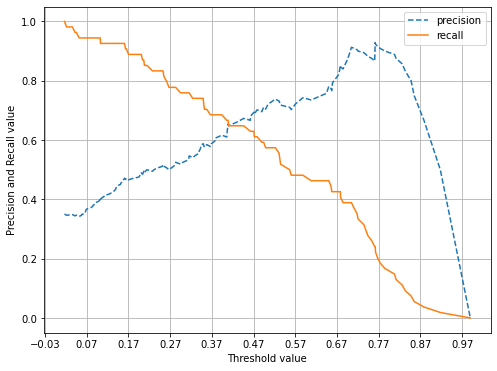

In [10]:
precision_recall_curve_plot(y_test, pred_proba)

재현율 곡선을 보면 임곗값을 0.42 정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것 같습니다. 하지만 두 개의 지표 모두 0.7이 안 되는 수치로 보입니다. 여전히 두 지표의 값이 낮습니다. 임곗값을 인위적으로 조작하기 전에 데이터 값을 다시 점검하겠습니다. 먼저 원본 데이터 DataFrame의 describe() 메서드를 호출해 피쳐 값의 분포도를 살펴보겠습니다.

In [11]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min() 값이 0으로 돼 있는 피쳐가 상당히 많습니다. 예를 들어 Glucose 피쳐는 포도당 수치인데 min 값이 0인 것은 말이 되지 않습니다. Glucose 피쳐의 히스토그램을 확인해 보면 0 값이 일정 수준 존재하는 것을 알 수 있습니다.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Glucose', ylabel='Density'>

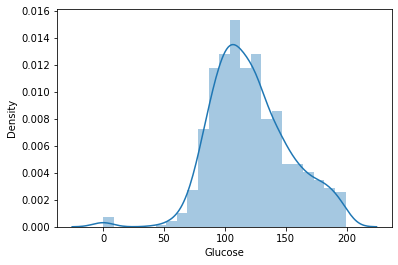

In [12]:
sns.distplot(diabetes_data['Glucose'])

min() 값이 0으로 돼 있는 피쳐에 대해 0값의 건수 및 전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지 확인해 보겠습니다. 확인할 피쳐는 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'입니다 (Pregnancies는 출산 횟수를 의미하므로 제외합니다).

In [13]:
# 0값을 검사할 피쳐 명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print(f'Feature: {feature}, Zero count: {zero_count}, Percentage: {100 * zero_count / total_count}')

Feature: Glucose, Zero count: 5, Percentage: 0.6510416666666666
Feature: BloodPressure, Zero count: 35, Percentage: 4.557291666666667
Feature: SkinThickness, Zero count: 227, Percentage: 29.557291666666668
Feature: Insulin, Zero count: 374, Percentage: 48.697916666666664
Feature: BMI, Zero count: 11, Percentage: 1.4322916666666667


SkinThickness와 Insulin의 0 값은 각각 전체의 29%, 48%로 대단히 많습니다. 전체 데이터 건수가 많지 않기 때문에 이들 데이터를 일괄적으로 삭제할 경우에는 학습을 효과적으로 수행하기 어려울 것 같습니다. 위 피쳐의 0 값을 평균값으로 대체하겠습니다.

In [14]:
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, diabetes_data[zero_features].mean())

다시 학습/데이터 세트로 나누고 로지스틱 회귀를 적용해 성능 평가 지표를 확인하겠습니다.

In [15]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# StandardScaler 클래스를 이용해 피쳐 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [16]:
get_clf_eval(y_test, pred, pred_proba)

Accuracy: 0.7987012987012987
Confusion Matrix:
[[89 11]
 [20 34]]
Precision: 0.7555555555555555, Recall: 0.6296296296296297
F1: 0.6868686868686867, AUC: 0.8438888888888889


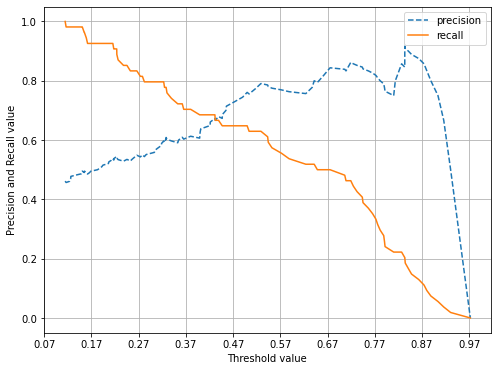

In [17]:
precision_recall_curve_plot(y_test, pred_proba)

앞에서 학습된 로지스틱 회귀 모델을 이용해 임곗값을 0.48로 낮춘 상태에서 다시 예측을 해보겠습니다. 사이킷런의 predict() 메서드는 임곗값을 마음대로 변환할 수 없으므로 별도의 로직으로 이를 구해야 합니다. 앞에서 살펴본 Binarizer 클래스를 이용해 predict_proba()로 추출한 예측 결과 확률값을 변환해 변경된 임곗값에 따른 예측 클래스 값을 구해 보겠습니다.

In [18]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba.reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba)

Accuracy: 0.7987012987012987
Confusion Matrix:
[[88 12]
 [19 35]]
Precision: 0.7446808510638298, Recall: 0.6481481481481481
F1: 0.6930693069306931, AUC: 0.8438888888888889
